In [1]:
from brian2 import *
import numpy as np
import pickle
set_device('cpp_standalone') #, build_on_run=False
start_scope()

def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel('Firing Rate')
    ylim([0,1.5*np.max(rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)')
            ylabel(str(list_of_params[i]))
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()
    

c:\users\ptolmachev\appdata\local\programs\python\python27\lib\site-packages\brian2\core\variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


In [2]:
eqs_adaptive = '''


dv/dt = (-Ifast- Iad - IsynE - IsynI)/(1*ms)  : volt 

Ifast = -(alpha*(v - U0)**2 )/(mV) - Ubase : volt
alpha = 0.004 : 1
U0 = -62.5*mV : volt
Ubase = -0*mV :volt

Iad = gad*m*(v-E_ad) :volt
gad =  0.3 : 1
E_ad = -70*mV : volt
dm/dt = (m_inf - m)/t_ad : 1
m_inf = 1.0/(1+exp(-(v+20*mV)/(0.10*mV))) : 1
t_ad = 4000*ms : second

IsynE = (gE*wE + g_Edrive)*(v - v_synE): volt
gE = 0.03 : 1
g_Edrive = 0.1*(y) : 1 #exitatory drive #1*t/60000/ms
y : 1
v_synE = -10*mV : volt
dwE/dt = -wE/tauE : 1
tauE = 10*ms : second

IsynI = gE*(wI_1 + wI_2 + wI_3)*(v - v_synI): volt
gI = 1 : 1
v_synI = -75*mV : volt
dwI_1/dt = -wI_1/tauI : 1
dwI_2/dt = -wI_2/tauI : 1
dwI_3/dt = -wI_3/tauI : 1
tauI = 15*ms : second
c = -55*mV   : volt 
'''

In [3]:
N = 1
nrn = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c', refractory = 'v >= 20*mV') 
nrn.v  = -(30 + 0.70*rand(1,N))*mV
nrn_statemon = StateMonitor(nrn, ['v','m','Ifast'], record = True)
nrn_spikemon = SpikeMonitor(nrn)
nrn_rate = PopulationRateMonitor(nrn)
duration = 20000
run(duration*ms, report='text')

WARNING    c:\users\ptolmachev\appdata\local\programs\python\python27\lib\site-packages\brian2\core\variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.06s, trying other methods took 0.14s). [brian2.stateupdaters.base.method_choice]


In [4]:
n = 0.1
p = 0.9
plot_vars(nrn_statemon, nrn_rate, n, p, show_variables = True)

# figure(figsize=(16,4))
# #[int(duration*n*10):int(duration*p*10)]
# plot(nrn_statemon.t/ms,nrn_statemon.v[0]/mV )
# plt.show()

NameError: global name 'figure' is not defined

# Fast-currents averaging (for adapting)

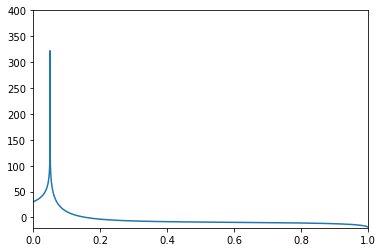

In [36]:
import numpy as np
from matplotlib import pyplot as plt

def Period(m, a, U0, Ub, g, Ead, vt,vr):
    A = a
    B = -(2*a*U0 + g*m)
    C = a*U0**2 + Ub +g*m*Ead
    
    x = A**(0.5)
    y = B/(2.0*x)
    z = C - (B/(2.0*x))**2
    z= -z
    
    aux_1 = np.log( abs( (x*vt + y - z**0.5)/(x*vt + y + z**0.5) ) )
    aux_2 = np.log( abs( (x*vr + y - z**0.5)/(x*vr + y + z**0.5) ) )
    T = ( (1.0/(2*x*(z**0.5))) *(aux_1 - aux_2))  
    return T

def v_avg(m, a, U0, Ub, g, Ead, vt,vr):
    A = a
    B = -(2*a*U0 + g*m)
    C = a*U0**2 + Ub +g*m*Ead
    
    x = A**(0.5)
    y = B/(2.0*x)
    z = C - (B/(2.0*x))**2
    
    res = (1.0/(2*x**2))*np.log((x*vt + y)/(x*vr + y))
    T = Period(m, a, U0, Ub, g, Ead, vt,vr) #period
    res = res/T - y/x
    return res


def v2_avg(m, a, U0, Ub, g, Ead, vt,vr):
    A = a
    B = -(2*a*U0 + g*m)
    C = a*U0**2 + Ub +g*m*Ead
    
    x = A**(0.5)
    y = B/(2.0*x)
    z = C - (B/(2*x))**2
    
   
    res = (vt - vr) 
    T = Period(m, a, U0, Ub, g, Ead, vt,vr)
    res = res/T - B*v_avg(m, a, U0, Ub, g, Ead, vt,vr) - C
    return res

def I_fast(m, a, U0, Ub, g, Ead, vt,vr):
    return -a*(v2_avg(m, a, U0, Ub, g, Ead, vt,vr) - 2*v_avg(m, a, U0, Ub, g, Ead, vt,vr)*U0 + U0**2)


a = 0.004
U0 = -62.5
Ub = 0
g = 0.3
Ead = -70
vt = 20
vr = -55
m = np.linspace(0,1,1000000)
# plt.plot(m,v_avg(m,a,U0,Ub,g,Ead,vt,vr))
# plt.plot(m,41.9*m -61.3)
plt.plot(m,Period(m,a,U0,Ub,g,Ead,vt,vr))
# plt.plot(m,-21.2*m +15.3)
# plt.plot(m,94.2*m -13.3)
plt.xlim(0,1)
plt.ylim(-20,400)
plt.show()




# Bursting

In [1]:
from brian2 import *
import numpy as np
import pickle
from matplotlib import pyplot as plt
set_device('cpp_standalone') #, build_on_run=False
start_scope()

def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel('Firing Rate')
    ylim([0,1.5*np.max(rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)')
            ylabel(str(list_of_params[i]))
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()
    

c:\users\ptolmachev\appdata\local\programs\python\python36\lib\site-packages\brian2\core\variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


In [2]:
eqs_bursting = '''


dv/dt = rhs/(1*ms)  : volt # 
rhs = (-Ifast - Iburst)  : volt
Ifast = - alpha*(v - U0)**2 /(mV) - Ubase :volt
alpha = 0.004 : 1
U0 = -62.5*mV : volt
Ubase = -2*mV :volt

v_avg = (int(h < 14.0/53.0)*(-250*h + 27)*mV + int(h >= 14.0/53.0)*(15*h-43)*mV): volt
# v_avg = ind*(int(h < 14.0/53.0)*(-250*h + 27)*mV + int(h >= 14.0/53.0)*(15*h-43)*mV) + (1-ind)*(-71.6*mV): volt
#v_avg = ind*(int(h < 0.275)*(-250*h + 20.3+ 20*(0.275 - h)**0.25)*mV + int(h >= 0.275)*(1*h  -48.725 + 23*(h - 0.2750)**0.25)*mV) + (1-ind)*(-70*mV): volt

Iburst = gburst*h*(v-E_burst) :volt
gburst =  0.05 : 1
E_burst = 50*mV : volt
dh/dt = (h_inf - h)/t_burst : 1
h_inf = 1.0/(1+exp((v+61*mV)/(4*mV))) : 1
t_burst = 4000*ms : second

c = -50*mV   : volt
ind = int(h_inf<h) : 1
q = ind*v_avg+(1-ind)*(-76 + 12*(exp(1.5*Hz*(t-lastspike)-1)))*mV : volt 
'''

In [3]:
N = 1
nrn = NeuronGroup(N, eqs_bursting, threshold='v >= 20*mV', reset='v = c', refractory = 'v >= 20*mV',events={'custom_event': 'h > 0.36'}) 
# nrn.run_on_event('custom_event', 'ind = 1-ind')
#nrn.v  = -(30 + 0.70*rand(1,N))*mV
# synapse_1 = Synapses(nrn, nrn,on_pre='ind = 1-ind', on_event={'pre': 'custom_event'})
nrn.h  = rand(1,N)
nrn_statemon = StateMonitor(nrn, ['h','q','v_avg','v'], record = True)
nrn_spikemon = SpikeMonitor(nrn)
nrn_rate = PopulationRateMonitor(nrn)
duration = 20000
run(duration*ms, report='text')

WARNING    c:\users\ptolmachev\appdata\local\programs\python\python36\lib\site-packages\brian2\core\variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
WARNING    c:\users\ptolmachev\appdata\local\programs\python\python36\lib\site-packages\brian2\core\variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.03s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]


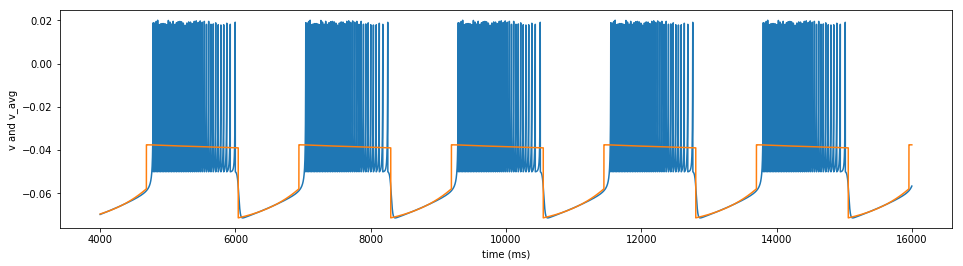

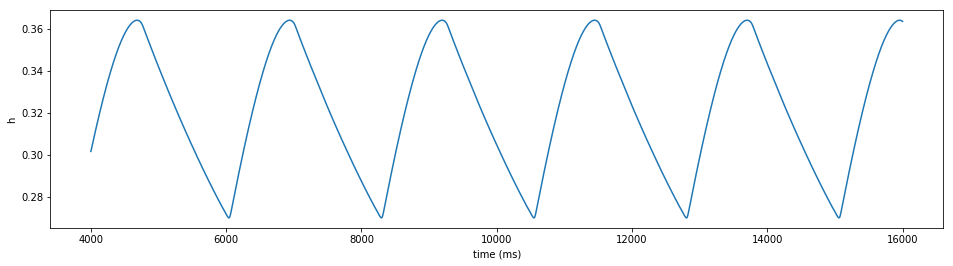

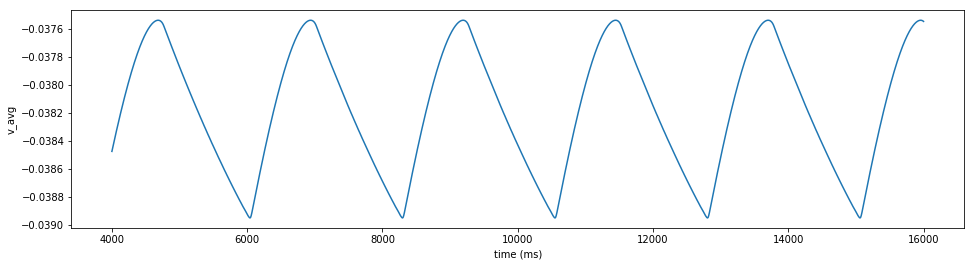

In [4]:
n = 0.2
p = 0.8

plt.figure(figsize=(16,4))
t = nrn_statemon.t[int(duration*n*10):int(duration*p*10)]/ms
plot(t, nrn_statemon.v[0][int(duration*n*10):int(duration*p*10)])
plot(t, nrn_statemon.q[0][int(duration*n*10):int(duration*p*10)])
xlabel('time (ms)')
ylabel('v and v_avg')
plt.show()

plt.figure(figsize=(16,4))
plot(t, nrn_statemon.h[0][int(duration*n*10):int(duration*p*10)])
xlabel('time (ms)')
ylabel('h')
plt.show()

plt.figure(figsize=(16,4))
plot(t, nrn_statemon.v_avg[0][int(duration*n*10):int(duration*p*10)])
xlabel('time (ms)')
ylabel('v_avg')
plt.show()
# plot_vars(nrn_statemon, nrn_rate, n, p, show_variables = True)

# figure(figsize=(16,4))
# #[int(duration*n*10):int(duration*p*10)]
# plot(nrn_statemon.t/ms,nrn_statemon.v[0]/mV )
# plt.show()

In [5]:
n = 0.2
p = 0.8
print (np.min(nrn_statemon.h[0][int(duration*n*10):int(duration*p*10)]))

0.2699918447652449


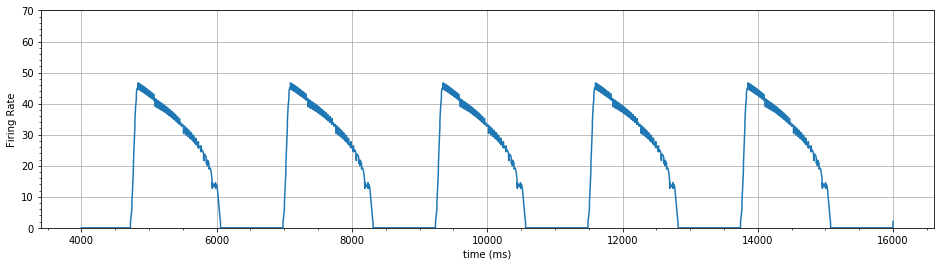

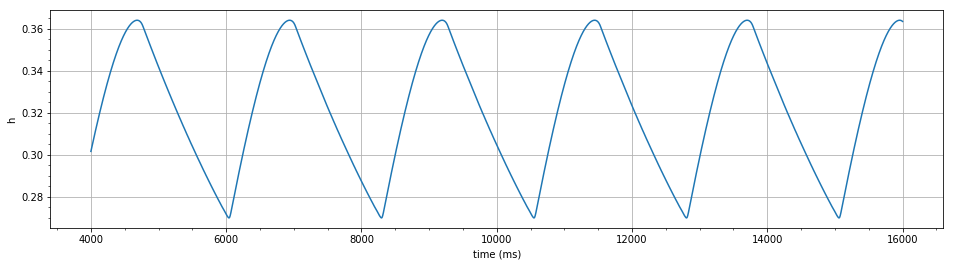

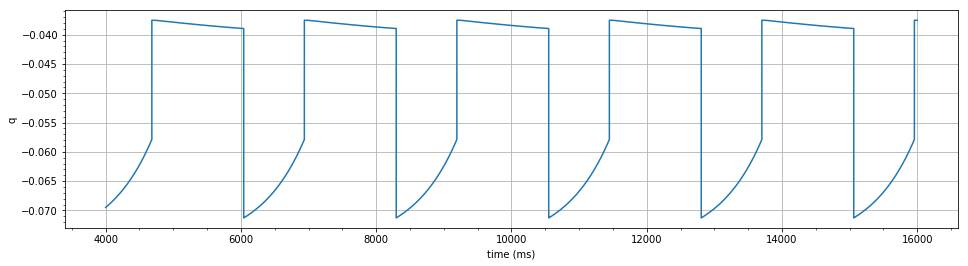

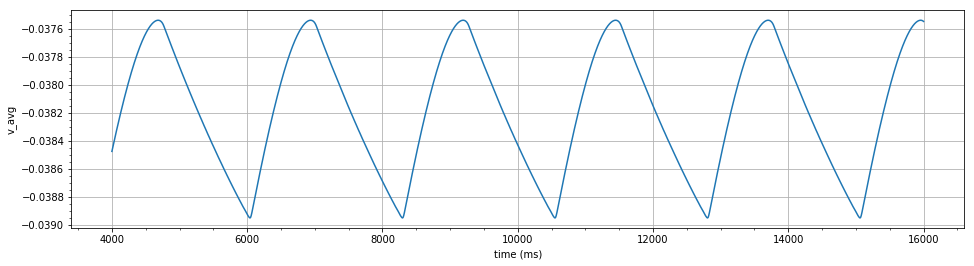

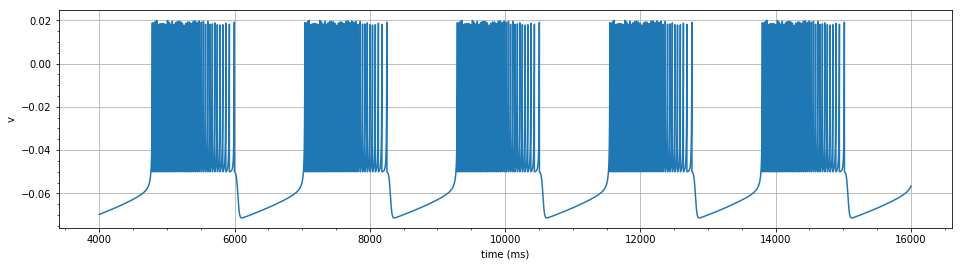

In [6]:
plot_vars(nrn_statemon, nrn_rate, n, p, show_variables = True)

# Firing-rate model (for bursting)

In [2]:
import numpy as np
from matplotlib import pyplot as plt


def averages(m, a, U0, Ub, g, Ead, vt,vr):
    A = a
    B = -(2*a*U0 + g*m)
    C = a*U0**2 + Ub +g*m*Ead
    
    x = A**(0.5)
    y = B/(2.0*x)
    z = C - (B/(2.0*x))**2
    
    T = []
    v_avg = []
    tmp1 = []
    tmp2 = []
    for i in range(len(z)):
        if z[i] < 0:
            aux_1 = np.log( abs( (x*vt + y[i] - (-z[i])**0.5)/(x*vt + y[i] + (-z[i])**0.5) ) )
            aux_2 = np.log( abs( (x*vr + y[i] - (-z[i])**0.5)/(x*vr + y[i] + (-z[i])**0.5) ) )
            T.append(((1.0/(2*x*((-z[i])**0.5))) *(aux_1 - aux_2)))
            tmp1.append( abs ((A*vt**2 + B[i]*vt + C[i])/( (A*vr**2 + B[i]*vr + C[i]) )))
            tmp2.append( (1.0/(2*x**2))*np.log(tmp1[i]) )
        else:
            T.append( (1.0/(x*(z[i]**0.5))) *(np.arctan((x*vt + y[i])/(z[i]**0.5)) - np.arctan((x*vr + y[i])/(z[i]**0.5))))
            tmp1.append( (A*vt**2 + B[i]*vt + C[i])/( (A*vr**2 + B[i]*vr + C[i]) ))
            tmp2.append( (1.0/(2*x**2))*np.log(tmp1[i]) )
        
        v_avg.append(tmp2[i]/T[i] - y[i]/x)
        
    T = np.array(T)
    v_avg = np.array(v_avg)
    v2_avg = (1.0/A) *(vt - vr)/T - (B/A)*v_avg - C/A
    return T, v_avg, v2_avg


def condition(m, a, U0, Ub, g, Ead, vt,vr):
    A = a
    B = -(2*a*U0 + g*m)
    C = a*U0**2 + Ub +g*m*Ead
    T,v,v2 = averages(m, a, U0, Ub, g, Ead, vt,vr)
    return m[np.argmin(A*v2+B*v+C)]
    
def v_low(m, a, U0, Ub, g, Ead, vt,vr):
    m_min = condition(m, a, U0, Ub, g, Ead, vt,vr)
    A = a
    B = -2*a*U0 - m_min*g
    C = a*U0**2 + Ub + m_min*g*Ead
    
    D = B**2 - 4*A*C
    if D < 0:
        print("err")
    else:
        return ((-B - D**0.5)/2/A)

def large_period(m,a, U0, Ub, g, Ead, vt,vr):
    A = a
    B = -(2*a*U0 + g*m)
    C = a*U0**2 + Ub +g*m*Ead
    
    x = A**(0.5)
    y = B/(2.0*x)
    z = C - (B/(2.0*x))**2
    if z < 0:
        aux_1 =  (x*vt + y - (-z)**0.5)/(x*vt + y + (-z)**0.5) 
        aux_2 =  (x*vr + y - (-z)**0.5)/(x*vr + y + (-z)**0.5) 
        return((1.0/(2*x*((-z)**0.5))) *(np.log(abs(aux_1/aux_2))) )
    else:
        return ( (1.0/(x*(z**0.5))) *(np.arctan((x*vt + y)/(z**0.5)) - np.arctan((x*vr + y)/(z**0.5))))
    
def m_max(m, a, U0, Ub, g, Ead, vt,vr):
    vl =  v_low(m, a, U0, Ub, g, Ead, vt,vr)
    return a*((0.45*vl+0.55*vr) - U0)**2 + Ub/(g*(vl - Ead))
    
a = 0.004
U0 = -62.5
Ub = -2
g = 0.05
Ead = 50
vt = 20
vr = -50
m = np.linspace(0,1,1000)
vl =  v_low(m, a, U0, Ub, g, Ead, vt,vr)
print("v_low:",vl)
print("h_max:",m_max(m, a, U0, Ub, g, Ead, vt,vr))
print("h_min:",condition(m, a, U0, Ub, g, Ead, vt,vr))

# print(v_low(m, a, U0, Ub, g, Ead, vt,vr))
# m = np.linspace(0,1,10000)
# # plt.plot(m,40*m + 90*(m-0.275)**0.4)
# # plt.plot(m,-790*m +235)
# # m = 0.247
# plt.title('average')
# plt.grid(True)
# # plt.ylim(0,230)
# plt.show()

('v_low:', -71.543086691727567)
('h_max:', 0.36058721215775846)
('h_min:', 0.27527527527527529)


C:\Users\ptolmachev\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in power


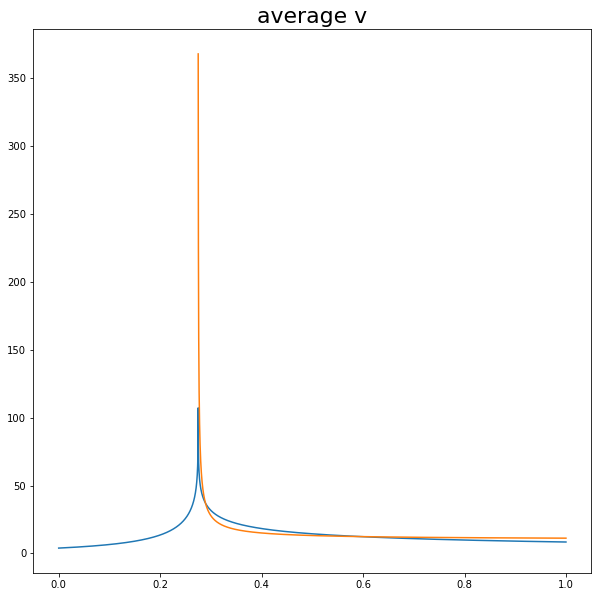

In [3]:
a = 0.004
U0 = -62.5
Ub = -2
g = 0.05
Ead = 50
vt = 20
vr = -50
plt.figure(figsize=(10,10))
m = np.linspace(0,1,10000)
plt.plot(m,averages(m,a,U0,Ub,g,Ead,vt,vr)[0])

#fit for v_average
# plt.plot(m,-250*m + 20.3+ 20*(0.275 - m)**0.25)
# plt.plot(m, 1*m  -48.725 + 23*(m - 0.275)**0.25)

# fit for Period
plt.plot(m,10 + 390.0/(400*(m-0.275)**0.8 + 1.0) )# 1.0/( 10*(m-0.275)*0.2 + 0.0025)
plt.title('average v', fontsize = 22)
# plt.ylim(-50,-40)
# plt.xlim(0.270,1)
plt.show()

In [10]:
from brian2 import *
import numpy as np
import pickle
set_device('cpp_standalone') #, build_on_run=False
start_scope()

def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel('Firing Rate')
    ylim([0,1.5*np.max(rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)')
            ylabel(str(list_of_params[i]))
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()
    

In [2]:
eqs_bursting = '''
T = int(h < 0.25)*(-0.8*h +0.23) + int(h >= 0.25)*(0.12*h +0.0) : 1
v_avg = (int(h < 0.251)*(-190*h -5)*mV + int(h >= 0.251)*(45.2*h -64)*mV): volt
v = ind*v_avg + (1-ind)*(-76 + 12*exp(1.5*Hz*(t-lastspike)))*mV : volt 
Ifast = (0.004/mV)*(v + 62.5*mV )**2 + 2*mV : volt
rhs = (-Ifast-0.05*h*(v - 50*mV)) : volt 
f = ind*(1000.0/T) : 1
dh/dt = (h_inf - h)/t_burst : 1
h_inf = 1.0/(1+exp((v+61*mV)/(4*mV))) : 1
t_burst = 4000*ms : second
ind = int(rhs > 0*mV)*(int(v >= -55*mV)) : 1 # 1 if spikes
'''

In [ ]:
N = 1
nrn = NeuronGroup(N, eqs_bursting, threshold = 'rhs < 0*mV', reset = 'v = -55*mV') 
nrn.h  = rand(1,N)
nrn_statemon = StateMonitor(nrn, ['f','h','v'], record = True)
duration = 40000
run(duration*ms, report='text')

In [ ]:
n = 0.0
m = 0.9
list_of_params = nrn_statemon.record_variables
for i in range(len(list_of_params)):
    figure(figsize=(16,4))
    plot(nrn_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('nrn_statemon.'+str(nrn_statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel(str(list_of_params[i]))
    # ylim([0,60])
    plt.grid(True)
    plt.minorticks_on()
    show()

In [7]:
#### import scipy
import numpy as np
from matplotlib import pyplot as plt

def averages(m, a, U0, Ub, g, Ead, vt,vr): # produces an array
    A = a
    B = -(2*a*U0 + g*m)
    C = a*U0**2 + Ub +g*m*Ead
    
    x = A**(0.5)
    y = B/(2.0*x)
    z = C - (B/(2.0*x))**2
    
    T = []
    v_avg = []
    tmp1 = []
    tmp2 = []
    for i in range(len(z)):
        if z[i] < 0:
            aux_1 = np.log( abs( (x*vt + y[i] - (-z[i])**0.5)/(x*vt + y[i] + (-z[i])**0.5) ) )
            aux_2 = np.log( abs( (x*vr + y[i] - (-z[i])**0.5)/(x*vr + y[i] + (-z[i])**0.5) ) )
            T.append(((1.0/(2*x*((-z[i])**0.5))) *(aux_1 - aux_2)))
            tmp1.append( abs ((A*vt**2 + B[i]*vt + C[i])/( (A*vr**2 + B[i]*vr + C[i]) )))
            tmp2.append( (1.0/(2*x**2))*np.log(tmp1[i]) )
        else:
            T.append( (1.0/(x*(z[i]**0.5))) *(np.arctan((x*vt + y[i])/(z[i]**0.5)) - np.arctan((x*vr + y[i])/(z[i]**0.5))))
            tmp1.append( (A*vt**2 + B[i]*vt + C[i])/( (A*vr**2 + B[i]*vr + C[i]) ))
            tmp2.append( (1.0/(2*x**2))*np.log(tmp1[i]) )
        
        v_avg.append(tmp2[i]/T[i] - y[i]/x)
        
    T = np.array(T)
    v_avg = np.array(v_avg)
    v2_avg = (1.0/A) *(vt - vr)/T - (B/A)*v_avg - C/A
    return T, v_avg, v2_avg


def m_min(m, a, U0, Ub, g, Ead, vt,vr):
    A = a
    B = -(2*a*U0 + g*m)
    C = a*U0**2 + Ub +g*m*Ead
    T,v,v2 = averages(m, a, U0, Ub, g, Ead, vt,vr)
    return m[np.argmin(A*v2+B*v+C)]

def m_max(m, a, U0, Ub, g, Ead, vt,vr):
    vl =  v_low(m, a, U0, Ub, g, Ead, vt,vr)
    return a*((0.45*vl+0.55*vr) - U0)**2 + Ub/(g*(vl - Ead))
    
def v_low(m, a, U0, Ub, g, Ead, vt,vr):
    m_MIN = m_min(m, a, U0, Ub, g, Ead, vt,vr)
    A = a
    B = -2*a*U0 - m_MIN*g
    C = a*U0**2 + Ub + m_MIN*g*Ead
    
    D = B**2 - 4*A*C
    if D < 0:
        print("err")
    else:
        return ((-B - D**0.5)/2/A)

def large_period(m,a, U0, Ub, g, Ead, vt,vr):
    A = a
    B = -(2*a*U0 + g*m)
    C = a*U0**2 + Ub +g*m*Ead
    
    x = A**(0.5)
    y = B/(2.0*x)
    z = C - (B/(2.0*x))**2
    if z < 0:
        aux_1 =  (x*vt + y - (-z)**0.5)/(x*vt + y + (-z)**0.5) 
        aux_2 =  (x*vr + y - (-z)**0.5)/(x*vr + y + (-z)**0.5) 
        return((1.0/(2*x*((-z)**0.5))) *(np.log(abs(aux_1/aux_2))) )
    else:
        return ( (1.0/(x*(z**0.5))) *(np.arctan((x*vt + y)/(z**0.5)) - np.arctan((x*vr + y)/(z**0.5))))
    


def h_inf(v):
    return 1.0/(1+np.exp((v+61)/4))


def avg(m, a, U0, Ub, g, Ead, vt,vr): #produces floats
    A = a
    B = -(2*a*U0 + g*m)
    C = a*U0**2 + Ub +g*m*Ead
    
    x = A**(0.5)
    y = B/(2.0*x)
    z = C - (B/(2.0*x))**2
    
    if z < 0:
        aux_1 = np.log( abs( (x*vt + y - (-z)**0.5)/(x*vt + y + (-z)**0.5) ) )
        aux_2 = np.log( abs( (x*vr + y - (-z)**0.5)/(x*vr + y + (-z)**0.5) ) )
        T = (((1.0/(2*x*((-z)**0.5))) *(aux_1 - aux_2)))
        tmp1 = ( abs ((A*vt**2 + B*vt + C)/( (A*vr**2 + B*vr + C) )))
        tmp2 = ( (1.0/(2*x**2))*np.log(tmp1) )
    else:
        T = ( (1.0/(x*(z**0.5))) *(np.arctan((x*vt + y)/(z**0.5)) - np.arctan((x*vr + y)/(z**0.5))))
        tmp1 = ( (A*vt**2 + B*vt + C)/( (A*vr**2 + B*vr + C) ))
        tmp2 = ( (1.0/(2*x**2))*np.log(tmp1) )
        
    return tmp2/T - y/x,T

In [24]:
import numba

@numba.jit
def oscillations(dt,T,tau,h_min,h_max):
    # computation
    h = np.zeros(int(T/dt))
    v = np.zeros(int(T/dt))
    t = np.zeros(int(T/dt))
    f = np.zeros(int(T/dt))
    h[0] = h_min + (h_max - h_min)*np.random.rand()
    ind = True
    v[0] =  1*h[0]  -48.725 + 23*(h[0] - h_min)**0.25#avg(h[0], a, U0, Ub, g, Ead, vt,vr)[0]
    t[0] = 0
    i = 1
    val = 'top'

    while i != int(T/dt) :
        h[i] = h[i-1] + dt*(h_inf(v[i-1]) - h[i-1])/tau

        if (abs(h[i]-h_min) < 0.0001):
            val = 'bot'  
        if (abs(h[i]-h_max) < 0.0001):
            val = 'top' 

        if val == 'top':
            ind = True
            tmp1 = 1*h[i] -48.725 + 23*(h[i] - h_min)**0.25
            v[i] = tmp1
            f[i] = 1000.0/(10.0 + 390.0/(400*(h[i]- h_min)**0.8 + 1.0))
        else:
            ind = False
            v[i] = (vl+vr)/2.0  
            f[i] = 0
        t[i] = i*dt
        i += 1
    
    return t,h,v,f
      
a = 0.004
U0 = -62.5
Ub = -2
g = 0.05
Ead = 50
vt = 20
vr = -50
m = np.linspace(0,1,10000)
h_min = m_min(m, a, U0, Ub, g, Ead, vt,vr)
h_max = m_max(m, a, U0, Ub, g, Ead, vt,vr)
vl = v_low(m, a, U0, Ub, g, Ead, vt,vr)
params = [a,U0,Ub,g,Ead,vt,vr]

t,h,v,f = oscillations(0.1,5000,2000,h_min,h_max)


NameError: name 'timit' is not defined

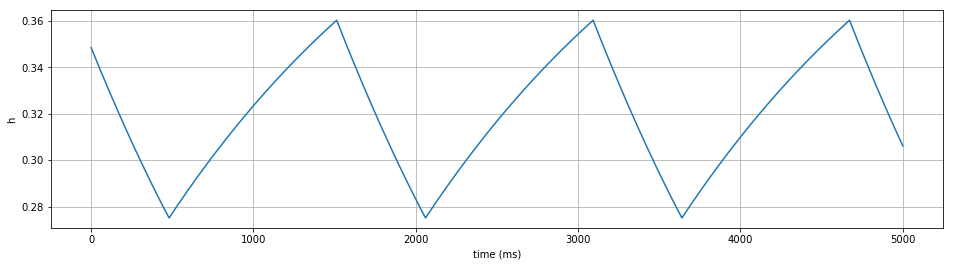

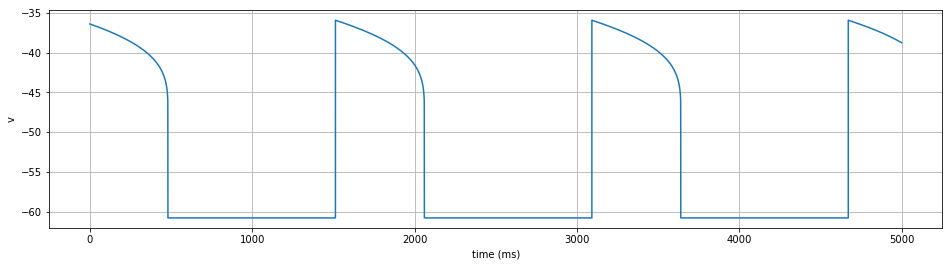

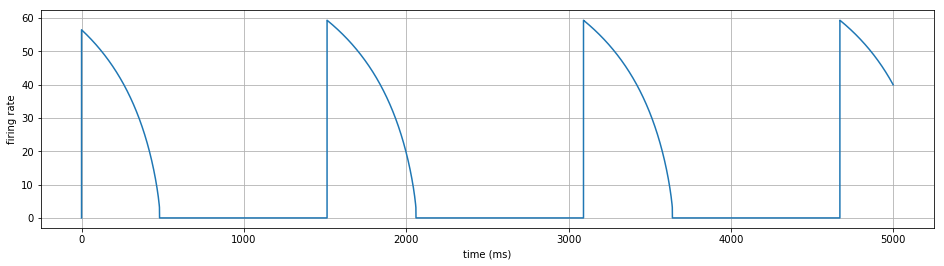

In [25]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (16,4))
plt.plot(t,h)
plt.xlabel('time (ms)')
plt.ylabel('h')
# plt.ylim([0.25,0.4])
plt.grid(True)
plt.show()

fig = plt.figure(figsize = (16,4))
plt.plot(t,v)
plt.xlabel('time (ms)')
plt.ylabel('v')
# plt.ylim([-70,-30])
plt.grid(True)
plt.show()

fig = plt.figure(figsize = (16,4))
plt.plot(t,f)
plt.xlabel('time (ms)')
plt.ylabel('firing rate')
# plt.ylim([-70,-30])
plt.grid(True)
plt.show()